In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,cross_val_score,train_test_split,RepeatedStratifiedKFold,KFold
from sklearn.linear_model import LinearRegression
from numpy import mean,absolute
from sklearn.metrics import mean_absolute_error,confusion_matrix,auc
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from builtins import zip
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,auc,roc_auc_score,f1_score,average_precision_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

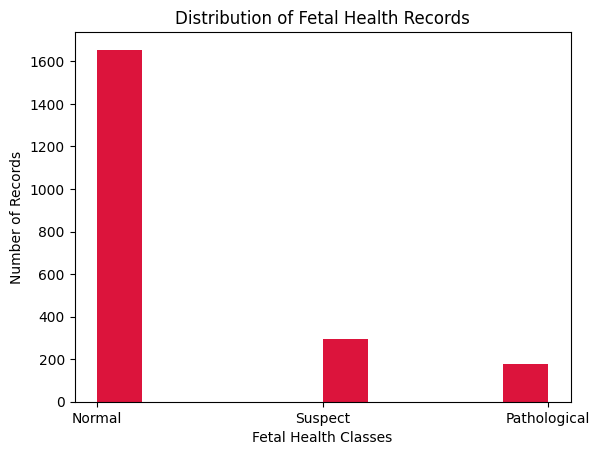

In [473]:
df = pd.read_csv('fetal_health.csv')
fetal_health = df['fetal_health']
plt.hist(fetal_health,color='crimson')

plt.xticks([1,2,3],['Normal','Suspect','Pathological'])

plt.xlabel('Fetal Health Classes')
plt.ylabel('Number of Records')
plt.title("Distribution of Fetal Health Records")
plt.show()

There is a data imbalance in this dataset with the normal fetal health condition overpowering the 2 other conditions.

**LINEAR REGRESSION MODEL**

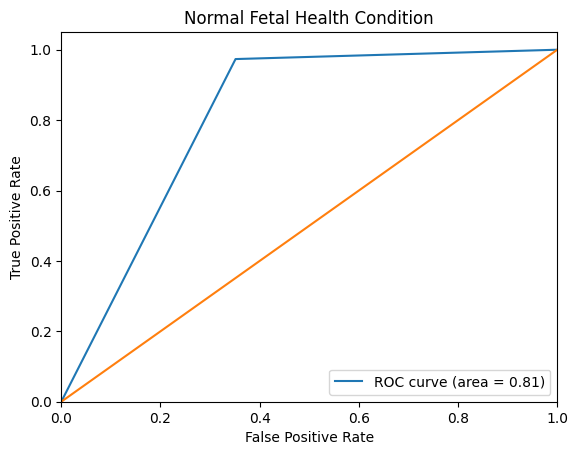

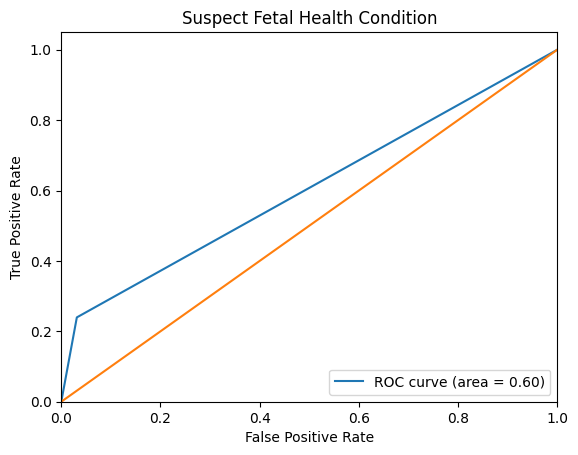

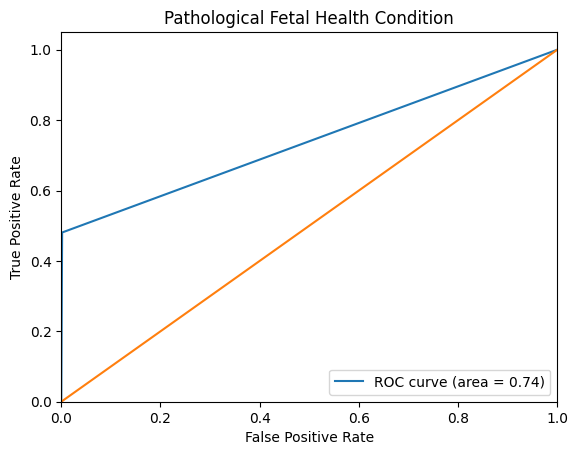

Mean Absolute Error: 0.277
Range of Data:  54.0
Variance:  96.84221570472027


In [474]:
X = df.iloc[:,:-1]
Y = fetal_health

X_train,X_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.3,random_state=1)

model=LinearRegression()
y_pred = model.fit(X_train, y_train).predict(X_test)

y = label_binarize(Y, classes=[1,2,3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = OneVsRestClassifier(model)
y_score = clf.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if i == 0:
        plt.title("Normal Fetal Health Condition")
    if i == 1:
        plt.title("Suspect Fetal Health Condition")
    if i == 2:
        plt.title("Pathological Fetal Health Condition")
    plt.legend(loc="lower right")
    plt.show()

cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error',cv=cv,n_jobs=-1)
error = mean(absolute(scores))

print(f'Mean Absolute Error: {error:.3f}')
print("Range of Data: ", (df.max() - df.min()).iloc[0])
print("Variance: ", df.var().iloc[0])


To address the data imbalance in this dataset, we took the approach of K-fold cross validation. This can help to reduce overfitting and bias in a machine learning model by training the model on different subsets of the data and evaluating its performance on different subsets of the data. This can give a more accurate assessment of the model's performance, because it takes into account the entire dataset, rather than just a single train-test split. Specifically, we used the StratifiedKFold class. This class can be used to split a dataset into folds while maintaining the same class balance in each fold. This can help ensure that each fold is representative of the overall dataset, which can improve the accuracy and reliability of your model.

For the first model, we decided to choose Linear Regression because of the numeric dataset values and the multiclass fetal health condition targets. We decided the MAE score is a more accurate score than the F1 score. The values in the dataset have a large range and high variance, so it may be more difficult for a model to make accurate predictions and a lower MAE showcases that the linear regression model is quite accurate. We got a low MAE of 0.277 which shows that our stratified k fold cross validation and linear regression approach was succesful.

As for the area under the ROC curve for the linear regression model, we can see that these values are 0.6, 0.74 and 0.81. This shows that the model we used is quite accurate for the three fetal health conditions but it can definitely be improved because the values could be close to 1.

**DECISION TREE MODEL**

In [475]:
model = DecisionTreeClassifier()

rfe = RFE(model,n_features_to_select=10)
fit = rfe.fit(X,Y)

selected_features = X.columns[fit.support_]
sorted_ranking = sorted(fit.ranking_, reverse=False)
ranked_features = list(zip(sorted_ranking, selected_features))

print("Feature : Rank\n")
for ranking, feature in ranked_features[:10]:
  print(f"{feature}: {ranking}")

cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

scores = cross_val_score(model, X, Y, scoring='accuracy',cv=cv,n_jobs=-1)
accuracy = mean(scores)
print("\nAccuracy: ",accuracy)


Feature : Rank

accelerations: 1
uterine_contractions: 1
abnormal_short_term_variability: 1
mean_value_of_short_term_variability: 1
percentage_of_time_with_abnormal_long_term_variability: 1
mean_value_of_long_term_variability: 1
histogram_max: 1
histogram_number_of_peaks: 1
histogram_mode: 1
histogram_mean: 1

Accuracy:  0.9214500841527151


**These are 10 Features that are most reflective to fealth health conditions.**

Recursive feature elimination (RFE) is a feature selection method that uses a decision tree model to determine the importance of each feature, and then eliminates the least important features until a specified number of features is left. The resulting list of features is ranked by their importance, with the most important feature having a ranking of 1. A lower ranking means that a feature is more important for the model, and is therefore more reflective for fetal health conditions. These features are strongly correlated with fetal health. In other words, the values of these features are good indicators of the health of the fetus.

The correlation is statistically significant at 90% but not 95%.

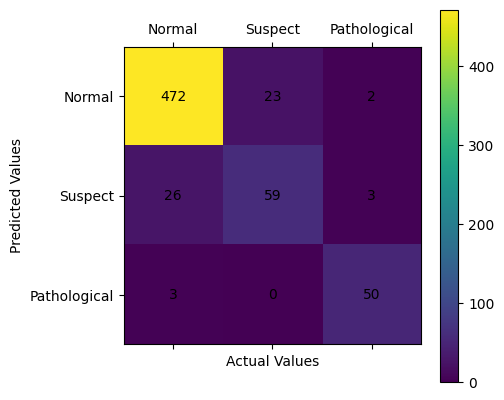

In [476]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.3,random_state=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test,y_pred,average='macro')

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.matshow(cm)
plt.colorbar()
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xticks([0,1,2],['Normal','Suspect','Pathological'])
plt.yticks([0,1,2],['Normal','Suspect','Pathological'])

for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i][j], ha='center', va='center')

plt.show()

For the confusion matrix, we decided to use the same decision tree model to display the matrix. Using pyplot, we implemented a confusion matrix with a colorbar and represented 1,2,3 as the respective fetal health conditions to show the predicted and actual values.

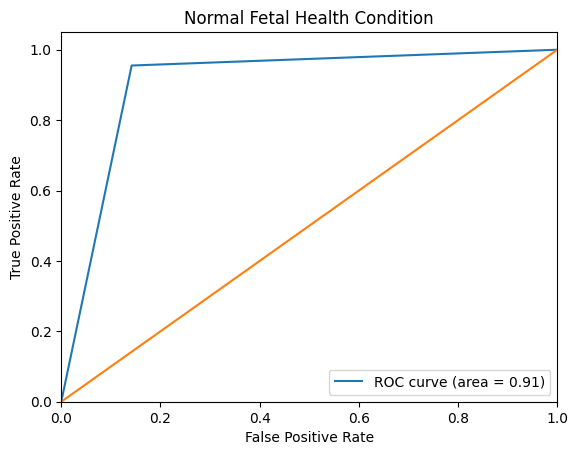

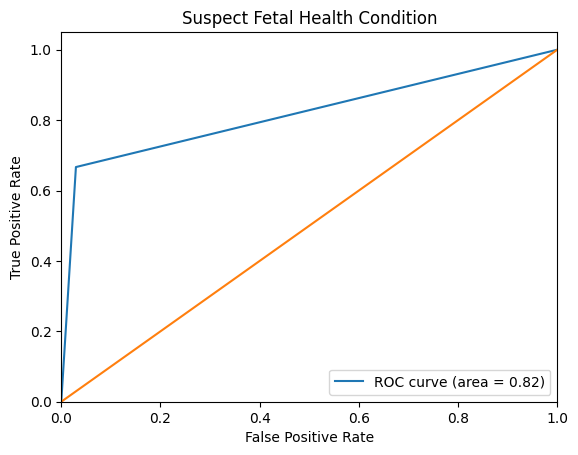

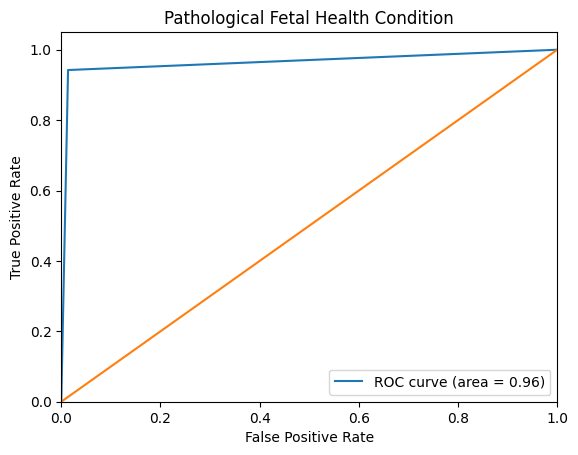

F1 Score: 0.855


In [477]:
y = label_binarize(Y, classes=[1,2,3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = OneVsRestClassifier(model)
y_score = clf.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if i == 0:
        plt.title("Normal Fetal Health Condition")
    if i == 1:
        plt.title("Suspect Fetal Health Condition")
    if i == 2:
        plt.title("Pathological Fetal Health Condition")
    plt.legend(loc="lower right")
    plt.show()

print(f"F1 Score: {f1:0.3f}")


For the second model, we decided to choose a decision tree classifier because of the ability to get the 10 features that are most reflective of the fetal health conditions.

As for the area under the ROC curve for the decision tree, we can see that these values are 0.9, 0.83 and 0.97. This shows that the model we used is very accurate for the three fetal health conditions because the values are very close to 1. This model is definitely better than the linear regression model. We calculated the F1 score of this model and got 0.832 which shows that this model and approach was successful.

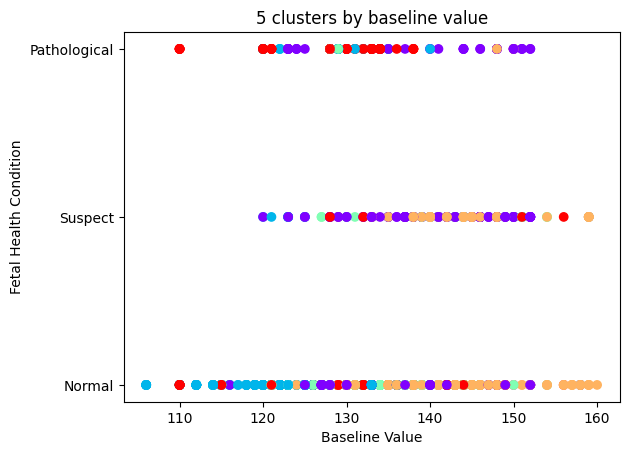

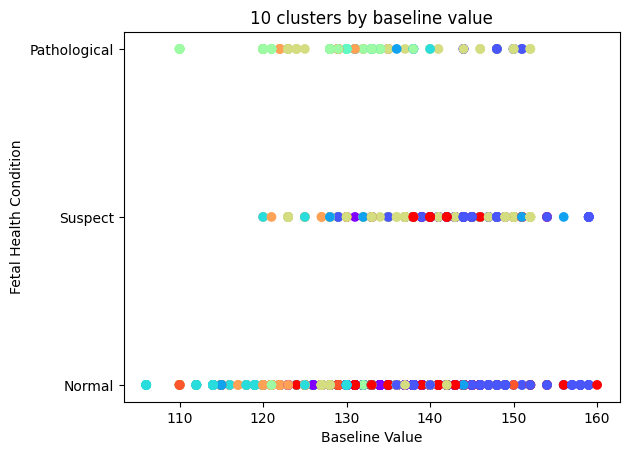

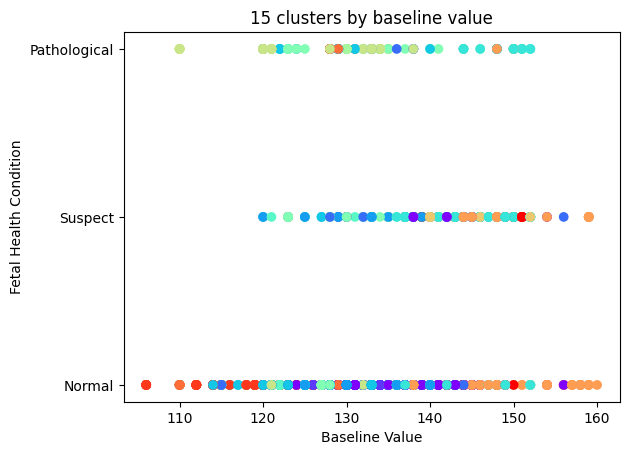

In [478]:
from sklearn.cluster import KMeans

for k in [5,10,15]:

    model = KMeans(n_clusters=k)
    model.fit(X)
    clusters = model.predict(X)
    plt.scatter(df.iloc[:,0],fetal_health,c=clusters,cmap="rainbow")
    plt.title(f"{k} clusters by baseline value")
    plt.yticks([1,2,3],['Normal','Suspect','Pathological'])
    plt.xlabel("Baseline Value")
    plt.ylabel("Fetal Health Condition")
    plt.show()

Since the baseline value was the highest ranking feature that is most reflective to fetal health conditions, we decided to use it as the x axis for our clusters and compare it with the fetal health conditions column. We created three different cluster visualizations with 5, 10 and 15 clusters using the KMeans clusters api from sklearn.